C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.2319
Epoch 2/10, Loss: 0.6977
Epoch 3/10, Loss: 0.5651
Epoch 4/10, Loss: 0.2471
Epoch 5/10, Loss: 0.2241
Epoch 6/10, Loss: 0.1348
Epoch 7/10, Loss: 0.0904
Epoch 8/10, Loss: 0.0836
Epoch 9/10, Loss: 0.0791
Epoch 10/10, Loss: 0.0602

Reporte de clasificación:
              precision    recall  f1-score   support

          d0       0.45      0.83      0.59         6
          d1       0.00      0.00      0.00         1
          d2       0.00      0.00      0.00         1
          d3       0.00      0.00      0.00         3
          d4       0.50      0.50      0.50         2
          d5       0.00      0.00      0.00         0
          d6       1.00      0.67      0.80         3
          d7       0.00      0.00      0.00         1
         d10       0.00      0.00      0.00         1

    accuracy                           0.44        18
   macro avg       0.22      0.22      0.21        18
weighted avg       0.37      0.44      0.38        18



C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification

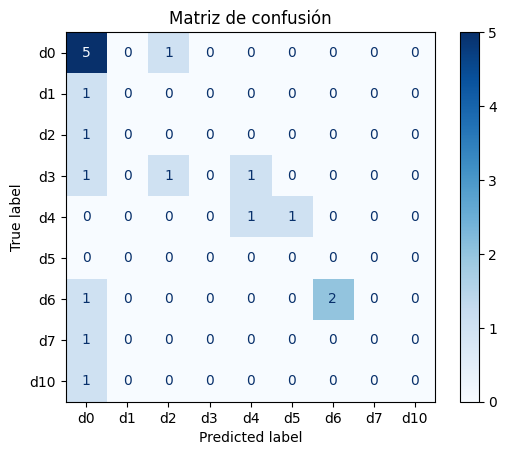

Predicción: 4 ductos


In [ ]:
import os
import re
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn, optim
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

# Ruta a la carpeta de imágenes
ruta = "img"

# Transformaciones con data augmentation para entrenamiento
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformación para validación y prueba (sin augmentación)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Clase personalizada para extraer etiquetas desde el nombre del archivo
class DuctoDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = set()

        for filename in os.listdir(img_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                match = re.search(r"_d(\d+)_", filename)
                if match:
                    label = int(match.group(1))
                    self.images.append(filename)
                    self.labels.append(label)
                    self.classes.add(label)

        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(self.classes))}
        self.idx_to_class = {idx: label for label, idx in self.class_to_idx.items()}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        label_idx = self.class_to_idx[label]
        if self.transform:
            image = self.transform(image)
        return image, label_idx

# Cargar datasets separados con diferentes transformaciones
full_dataset = DuctoDataset(ruta, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Aplicar las transformaciones específicas después de separar
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
model = model.to(device)

# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluación
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nReporte de clasificación:")
clases_usadas = unique_labels(y_true, y_pred)
print(classification_report(
    y_true, y_pred,
    labels=clases_usadas,
    target_names=[f"d{full_dataset.idx_to_class[c]}" for c in clases_usadas]
))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=clases_usadas)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[f"d{full_dataset.idx_to_class[c]}" for c in clases_usadas])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión")
plt.show()

# Guardar el modelo
torch.save(model.state_dict(), "modelo_ductos.pth")

# Función para predecir una imagen nueva
def predecir_imagen(imagen_path):
    if not os.path.exists(imagen_path):
        return f"Archivo no encontrado: {imagen_path}"
    image = Image.open(imagen_path).convert("RGB")
    image = transform_val(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)
        clase = full_dataset.idx_to_class[pred.item()]
    return f"Predicción: {clase} ductos"

# Ejemplo de predicción (reemplazar con imagen existente)
print(predecir_imagen("img_predic.jpg"))


In [ ]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib


   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB 991.0 kB/s eta 0:00:12
    --------------------------------------- 0.3/11.6 MB 3.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/11.6 MB 10.0 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.6 MB 12.2 MB/s eta 0:00:01
   ---------- ----------------------------- 3.1/11.6 MB 15.3 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.6 MB 17.9 MB/s eta 0:00:01
   -------------------- ------------------- 6.0/11.6 MB 20.1 MB/s eta 0:00:01
   ------------------------- -------------- 7.4/11.6 MB 21.6 MB/s eta 0:00:01
   ----------------------------- ---------- 8.7/11.6 MB 22.2 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.6 MB 22.7 MB/s eta 0:00:01
   -------------------------------------- - 11.3/11.6 MB 27.3 MB/s eta 0:00:01
   ---------------------------------------  11.6/11.6 MB 28.5 MB/s eta


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.8 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 647.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.1 MB 3.6 MB/s eta 0:00:04
   - -------------------------------------- 0.5/11.1 MB 6.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.1 MB 12.3 MB/s eta 0:00:01
   ----------- ---------------------------- 3.2/11.1 MB 17.2 MB/s eta 0:00:01
   ---------------- ----------------------- 4.5/11.1 MB 20.3 MB/s eta 0:00:01
   ---------------------- ----------------- 6.3/11.1 MB 23.6 MB/s eta 0:00:01
   ---------------------------- ----------- 8.0/11.1 MB 25.6 MB/s eta 0:00:01
   ------------------------------------ --- 10.1/11.1 MB 26.8 MB/s eta 0:00:01
   


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/104.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/104.0 kB ? eta -:--:--
     -------------- ---------------------- 41.0/104.0 kB 653.6 kB/s eta 0:00:01
     ------------------------------------ 104.0/104.0 kB 997.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.2/8.1 MB 9.6 MB/s eta 0:00:01
   - -------------------------------------- 0.3/8.1 MB 4.2 MB/s eta 0:00:02
   -- ------------------------------------- 0.5/8.1 MB 4.2 MB/s eta 0:00:02
   --- ------------------------------------ 0.7/8.1 MB 4.0 MB/s eta 0:00:02
   ---- ----------------------------------- 1.0/8.1 MB 4.3 MB/s eta 0:00:02
   ----- ---------------------------------- 1.2/8.1 MB 4.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.1 MB 4.0 MB/s eta 0:00:02
   ------- -------------------------------- 1.5/8.1 MB 4.0 MB/s eta 0:00:02
   -------- ----


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
